In [3]:
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import pickle
import re
!pip install transformers
import transformers
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report

     |████████████████████████████████| 3.5 MB 4.3 MB/s 
     |████████████████████████████████| 895 kB 34.7 MB/s 
     |████████████████████████████████| 67 kB 5.8 MB/s 
     |████████████████████████████████| 6.8 MB 34.9 MB/s 
     |████████████████████████████████| 596 kB 48.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [6]:
pd.set_option('display.max_colwidth', None)

In [46]:
df = pd.read_csv('/content/drive/My Drive/final_dataset.csv', index_col=0)

In [47]:
df

,title,flair
0,Got my hands on the new PS5,Non-Political
1,All these things were making Chanbeli Begum sad Sometimes she was also a green jasmine bull Children used to come to play in the garden A girl sometimes gave water to Chanbeli Begum,AskIndia
2,I need a huge favour of 149 INR to buy instamojo notes as I can not pay from Nepal,AskIndia
3,UK Sikhs push back against anti India forces pass resolution thanking PM Modi Hindustan Times,Politics
4,How Can I Scrape Data From LinkedIn To An Excel Sheet,Business/Finance
...,...,...
167700,What is ailing rural India BASTAR SPECIAL PART 1 2 NP,Non-Political
167701,People is court should decide on euthanasia and living will says SC The government is examining a report by the Law Commission on the subject and may table a Bill in Parliament legalising passive euthanasia,Business/Finance
167702,Tifu by sending Kiss and i love you sticker on hike to my best friend is girlfriend,Non-Political
167703,Bad debt and good times How Vijay Mallya gamed the banking system,Non-Political


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167705 entries, 0 to 167704
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   title   167295 non-null  object
 1   flair   167705 non-null  object
dtypes: object(2)
memory usage: 3.8+ MB


In [49]:
# sr = pd.isnull(df['full_text'])
sr = pd.isnull(df['title'])
drop_arr = sr.loc[sr==True].index.tolist()
df.drop(drop_arr, axis=0, inplace=True)
df = df.reset_index(drop=True)

In [50]:
df.drop(df[df['flair']=='Non-Political'].index, inplace=True)

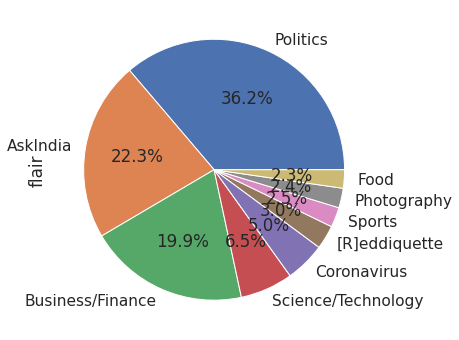

In [51]:
plt.figure(figsize=(8, 6))
d = df['flair'].value_counts()
d.plot.pie(autopct='%1.1f%%')

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118762 entries, 1 to 167291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   title   118762 non-null  object
 1   flair   118762 non-null  object
dtypes: object(2)
memory usage: 2.7+ MB


(array([2.4716e+04, 5.9339e+04, 2.2337e+04, 6.4120e+03, 2.8600e+03,
        1.5750e+03, 1.1300e+03, 3.4100e+02, 5.0000e+01, 2.0000e+00]),
 array([ 0. ,  7.3, 14.6, 21.9, 29.2, 36.5, 43.8, 51.1, 58.4, 65.7, 73. ]),
 <a list of 10 Patch objects>)

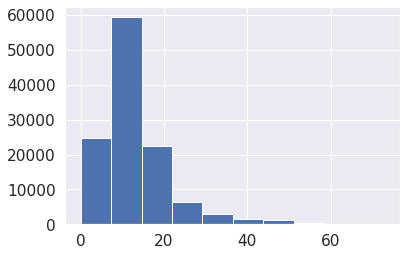

In [53]:
# lengths = list(df.full_text.str.split().str.len())
lengths = list(df.title.str.split().str.len())
plt.hist(lengths, range=(0, max(lengths)))

In [54]:
# MAX_SEQ_LEN = df.full_text.str.split().str.len().max()
MAX_SEQ_LEN = 50

In [55]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [56]:
def create_bert_input_features(tokenizer, docs, max_seq_length):
    all_ids, all_masks = [], []
    for doc in tqdm.tqdm(docs, desc="Converting docs to features"):
        tokens = tokenizer.tokenize(doc)
        if len(tokens) > max_seq_length-2:
            tokens = tokens[0 : (max_seq_length-2)]
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        ids = tokenizer.convert_tokens_to_ids(tokens)
        masks = [1] * len(ids)
        # Zero-pad up to the sequence length.
        while len(ids) < max_seq_length:
            ids.append(0)
            masks.append(0)
        all_ids.append(ids)
        all_masks.append(masks)
    encoded = np.array([all_ids, all_masks])
    return encoded

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['title'], df['flair'], test_size=0.2, stratify=df['flair'])

In [58]:
X_train.shape, X_test.shape

((95009,), (23753,))

In [59]:
train_features_ids, train_features_masks = create_bert_input_features(tokenizer, X_train, max_seq_length=MAX_SEQ_LEN)
test_features_ids, test_features_masks = create_bert_input_features(tokenizer, X_test, max_seq_length=MAX_SEQ_LEN)

Converting docs to features: 100%|██████████| 23753/23753 [00:15<00:00, 1557.81it/s]


In [60]:
enc = OneHotEncoder()
train_labels_one_hot = enc.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
test_labels_one_hot = enc.transform(np.array(y_test).reshape(-1, 1)).toarray()

In [61]:
train_labels_one_hot.shape, test_labels_one_hot.shape

((95009, 9), (23753, 9))

In [62]:
y_train

79296               Politics
45014               AskIndia
50892               Politics
116383              Politics
69904          [R]eddiquette
                 ...        
14926       Business/Finance
162942              Politics
88616            Photography
149944    Science/Technology
32883               Politics
Name: flair, Length: 95009, dtype: object

In [63]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced' , classes=enc.categories_[0] , y=y_train)
class_weights = {i:class_weights[i] for i in range(len(class_weights))}

In [64]:
class_weights

{0: 0.4993404075282889,
 1: 0.558843597435445,
 2: 2.238930128431719,
 3: 4.878260423084822,
 4: 4.575880171458845,
 5: 0.3067428608326473,
 6: 1.6980144049470092,
 7: 4.488331443688587,
 8: 3.7594571066793288}

In [65]:
inp_id = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype='int32', name="bert_input_1_ids")
inp_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype='int32', name="bert_input_1_masks")
inputs = [inp_id, inp_mask]

bert_layer = transformers.TFBertModel.from_pretrained('bert-base-cased')
for layer in bert_layer.layers:
    layer.trainable = False

hidden_state = bert_layer(inputs)[0]

pooled_output = hidden_state[:, 0]
dense1 = tf.keras.layers.Dense(256, activation='relu')(pooled_output)
# drop1 = tf.keras.layers.Dropout(0.1)(dense1)
dense2 = tf.keras.layers.Dense(64, activation='relu')(dense1)
# drop2 = tf.keras.layers.Dropout(0.1)(dense2)
output = tf.keras.layers.Dense(9, activation='softmax')(dense2)

model = tf.keras.Model(inputs=[inp_id, inp_mask], outputs=output)
model.summary()

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 bert_input_1_ids (InputLayer)  [(None, 50)]         0           []                               
                                                                                                  
 bert_input_1_masks (InputLayer  [(None, 50)]        0           []                               
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['bert_input_1_ids[0][0]',       
                                thPoolingAndCrossAt               'bert_input_1_masks[0][0]']     
                                tentions(last_hidde                                         

In [66]:
def scheduler(epoch, lr):
    return lr * tf.math.exp(-0.1)
callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [67]:
# tf.optimizers.Adam(learning_rate=1e-3, epsilon=1e-08)
model.compile(optimizer='adam',
              loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])

In [ ]:
history = model.fit([train_features_ids, train_features_masks], 
                    train_labels_one_hot, callbacks=[callback_lr],
                    validation_split = 0.1, class_weight=class_weights,
                    epochs=30, batch_size=128, shuffle=True)

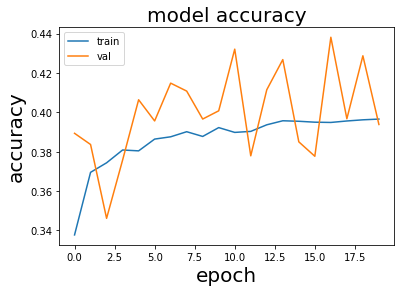

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy']) 
plt.title('model accuracy', fontsize=20)
plt.ylabel('accuracy', fontsize=20)
plt.xlabel('epoch', fontsize=20)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

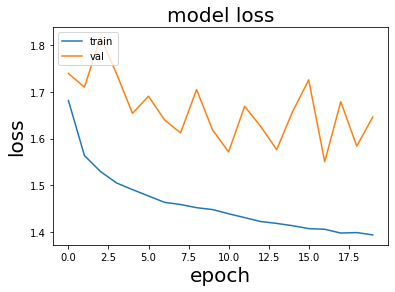

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.xlabel('epoch', fontsize=20)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [69]:
y_pred = model.predict([test_features_ids, test_features_masks])
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(test_labels_one_hot, axis=1)

In [70]:
y_pred, y_test

(array([1, 6, 0, ..., 4, 5, 5]), array([1, 1, 0, ..., 4, 5, 5]))

Text(115.49999999999999, 0.5, 'True labels')

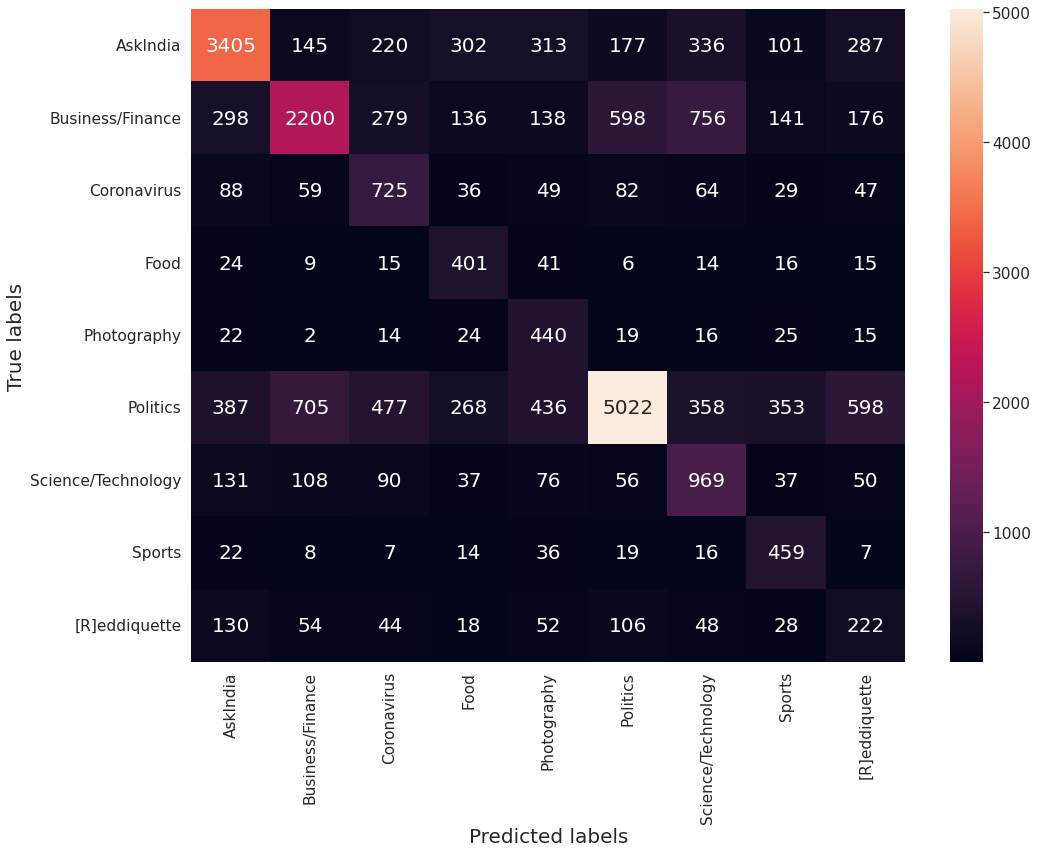

In [71]:
plt.figure(figsize=(16, 12))
sns.set(font_scale=1.4)
ticks = list(enc.categories_[0])
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', xticklabels=ticks, yticklabels=ticks, annot_kws={"fontsize":20})
plt.xlabel("Predicted labels", fontsize=20)
plt.ylabel("True labels", fontsize=20)

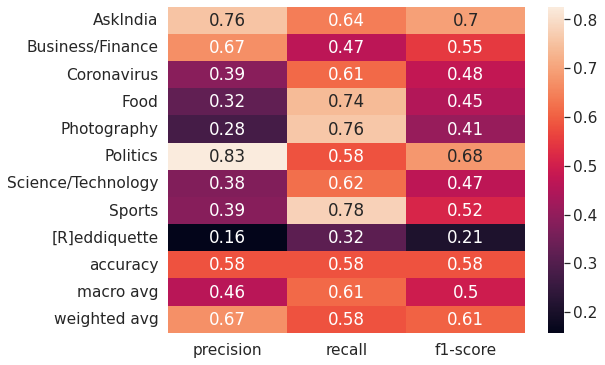

In [72]:
plt.figure(figsize=(8, 6))
report = classification_report(y_test, y_pred, output_dict=True, target_names=ticks)
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True)